## Intro to Geospatial Databases
- Databases provide one of the most popular ways to store large amounts of data, and one of the most popular open source databases is 
PostgreSQL. PostGIS extends PostgreSQL, adding geographic objects and the ability to query records spatially.
- Geospatial databases improve on basic relational database queries by allowing you to query your data by location or by location to
other features in the database.
- You may also perform geospatial operations such as:
  - measurements of features.
  - distances between features.
  - converting between projections etc.
  - create new geometries from existing features - buffer, union or clip operation

## Installing PostGreSQL and POSTGIS

- Download from https://postgresapp.com/
- NOTE: Working with PostgreSQL in Python requires that use another library called psyscopg2

In [13]:
pip install psycopg2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 272.9 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for psycopg2: filename=psycopg2-2.9.9-cp312-cp312-macosx_11_0_arm64.whl size=133113 sha256=3ce2d4cd5be655a5768f27d5d88f6513c5083a97ffb5597850a9f717e2c5d858
  Stored in directory: /Users/michaelkimollo/Library/Caches/pip/wheels/ff/ac/80/7ccec163e3d05ae2112311b895132409b9abfd7e0c1c6b5183
Successfully built psycopg2
Note: you may need to restart the kernel to use updated packages.


## Connecting to the database and creating table

In [3]:
import psycopg2
connection = psycopg2.connect(database="pythonspatial", user="postgres", password="")
cursor = connection.cursor()
query = "CREATE TABLE IF NOT EXISTS art_pieces (id SERIAL PRIMARY KEY, code VARCHAR(255), location GEOMETRY)"
cursor.execute(query)
connection.commit()

## Adding data to the table

In [ ]:
# import requests
# # url='https://coagisweb.cabq.gov/arcgis/rest/services/public/PublicArt/MapServer/0/query'
# url = 'https://coagisweb.cabq.gov/arcgis/rest/services/public/PublicArt/MapServer/0/query'
# params={"where":"1=1","outFields":"*","outSR":"4326","f":"json"}
# r=requests.get(url,params=params)
# # data=r.json()
# # data["features"][0]

In [107]:
with open('data/query.json', 'r') as file:
    data = json.load(file)

data["features"][0]


{'attributes': {'ART_CODE': '101'},
 'geometry': {'x': -106.59183830022498, 'y': 35.155500000061544}}

In [121]:
for a in data["features"]: 
    code = a['attributes']['ART_CODE']
    wkt = "POINT("+str(a["geometry"]["x"])+" "+str(a["geometry"]["y"])+")"
    if(a['geometry']['x']=='NaN'): 
        pass
    else: 
        cursor.execute("INSERT INTO art_pieces (code, location) VALUES ('{}', ST_GeomFromText('{}'))".format(code,wkt))
        connection.commit()

### Using Shapely
- Shapely makes the code cleaner. Instead of creating a string representation of the wkt, we create a point using 
shapely and then convert the point to the wkt.

In [132]:
from shapely.geometry import Point,MultiPoint

thepoints = []
for a in data["features"]: 
    code = a["attributes"]["ART_CODE"]
    p = Point(float(a["geometry"]["x"]),(float(a["geometry"]["y"])))
    thepoints.append(p)

    if(a["geometry"]["x"]=="NaN"):
        pass; 
    else: 
        cursor.execute("INSERT INTO art_pieces (code, location) VALUES ('{}', ST_GeomFromText('{}'))".format(code,p.wkt))
        connection.commit()

## Querying the data

In [144]:
# querying data normally, without considering the geospatial dimension
cursor.execute("SELECT * FROM art_pieces")
data = cursor.fetchall()
data[0]

(1, '101', '0101000020E610000023FFBFADE0A55AC06B658B6CE7934140')

Note how the geomery of this displayed. The geometry string is displayed as a WKB in hex - Well Known Binary. We can use 
shapely to convert the WKB to shapely point. 

In [159]:
from shapely.wkb import loads
aPoint = loads(data[0][2],hex=True)
aPoint.wkt  #this displays the shapely point in a WKT format

'POINT (-106.59183830022498 35.155500000061544)'

In [161]:
type(aPoint)

shapely.geometry.point.Point

Note: If you want the PostgreSQL to return the data in WKB without hex, you can do by using _AsBinary()

In [168]:
cursor.execute("SELECT id,code, ST_AsBinary(location) FROM art_pieces")
data = cursor.fetchall()
data[0]

(1, '101', <memory at 0x16936d0c0>)

In [174]:
from shapely.wkb import loads
pNoHex = loads(bytes(data[0][2]))
pNoHex.wkt

'POINT (-106.59183830022498 35.155500000061544)'

You may query directly to retrieve geometry back as follows 

In [181]:
cursor.execute("SELECT id,code, ST_AsText(location) FROM art_pieces")
data = cursor.fetchone()
data

(1, '101', 'POINT(-106.59183830022498 35.155500000061544)')

You can load WKT into a shapely Point using loads().

In [194]:
data[2]

'POINT(-106.59183830022498 35.155500000061544)'

In [202]:
from shapely.wkt import loads
pb = loads(data[2])
pb.coords[:]

[(-106.59183830022498, 35.155500000061544)]

## Changing the CRS

Currently the data in the database is using the World Geodetic System 84(WGS 84),latitude and longitude. What if we want data out 
in European Petroleum Survey Group (EPSG) 3857?
- You can change the spatial reference in your query using ST_Transform()

In [233]:
cursor.execute("UPDATE art_pieces SET location = ST_SetSRID(location, 4326)")

In [235]:
cursor.execute("SELECT Find_SRID('public','art_pieces', 'location')")
cursor.fetchall()

[(0,)]

In [240]:
cursor.execute("SELECT code, ST_AsText(ST_Transform(location,3857)) from art_pieces")
cursor.fetchone()

('101', 'POINT(-11865749.162299998 4185033.103399999)')

## Buffer

Note: A spatial database allows you to store spatial data, but you can also perform operations on the data and get different geometries
back. For example with ST_Buffer() you can return a polygon around the point with a specified radius. 

In [273]:
cursor.execute("SELECT ST_AsText(ST_Buffer(a.location,25.00,'quad_segs=3')) from art_pieces as a WHERE a.code='101'")
data = cursor.fetchall()
data[0][0]

'POLYGON((-81.59183830022498 35.155500000061544,-84.94120320561402 22.655500000061544,-94.09183830022498 13.504864905450578,-106.59183830022498 10.155500000061544,-119.09183830022498 13.504864905450574,-128.24247339483594 22.655500000061537,-131.591838300225 35.155500000061544,-128.24247339483594 47.65550000006154,-119.09183830022499 56.8061350946725,-106.59183830022498 60.155500000061544,-94.09183830022499 56.80613509467252,-84.94120320561402 47.65550000006155,-81.59183830022498 35.155500000061544))'

We can load this polygon into shapely to draw the polygon

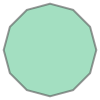

In [276]:
from shapely.geometry import Polygon
from shapely.wkt import loads

buffer = loads(data[0][0])
buffer

## Distance and Near
How do we query the database for the distance between two points and have it return records based on the distance from a specified point?
PostGIS offers ST_Distance(a,b) for calculating distance.

In [290]:
cursor.execute("SELECT ST_Distance(a.location::geography,b.location::geography) FROM art_pieces a, art_pieces b \
WHERE a.code='101' and b.code='102' ")
dist = cursor.fetchall()
dist[0]

(9560.45428363,)

We use ::geography to cast a geometry to a geography (in meters)

What if I want distance of multiple points from a given point?

In [308]:
cursor.execute("SELECT code, ST_Distance(location::geography,ST_GeometryFromText('POINT(-106.591838300225 35.1555000000615)')::geography) as d from art_pieces LIMIT 5")
cursor.fetchall()

[('101', 0.0),
 ('102', 9560.45428362),
 ('104', 4741.8711304),
 ('105', 9871.8424894),
 ('106', 7907.8263995)]

- These are distances of all points from the specified point in the query

## Lines in the database

In [5]:
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

connection = psycopg2.connect(database="pythonspatial",user="postgres", password="")
cursor = connection.cursor()

cursor.execute("CREATE TABLE IF NOT EXISTS lines (id SERIAL PRIMARY KEY, location GEOMETRY)")
thelines = [] 
thelines.append(LineString([(-106.635585, 35.086972), (-106.621294, 35.124997)]))
thelines.append(LineString([(-106.498309, 35.140108), (-106.497010, 35.069488)]))
thelines.append(LineString([(-106.663878, 35.106459), (-106.586506, 35.103979)]))

# Create a MultiLineString from the LineStrings
mls = MultiLineString(thelines)

for a in thelines: 
    cursor.execute("INSERT INTO lines (location) VALUES (ST_GeomFromText('{}'))".format(a.wkt))
    connection.commit()

In [22]:
cursor.execute("SELECT id, ST_AsText(location) FROM lines")
lines = cursor.fetchall()
lines

[(1, 'LINESTRING(-106.635585 35.086972,-106.621294 35.124997)'),
 (2, 'LINESTRING(-106.498309 35.140108,-106.49701 35.069488)'),
 (3, 'LINESTRING(-106.663878 35.106459,-106.586506 35.103979)')]

## Length of a line 
Lines have a length and can intersect at a point. We use ST_Length() to get sthe length of the line

In [20]:
cursor.execute("SELECT id, ST_Length(location::geography) AS length FROM lines ORDER BY length")
cursor.fetchall()

[(1, 4415.210268081443), (3, 7059.458405023586), (2, 7835.654054081599)]

## Intersecting Lines 
- You can use ST_Intersects() - It returns true or false if the two lines are intersecting or not.

In [54]:
cursor.execute("SELECT ST_Intersects(a.location::geography,b.location::geography) FROM lines a, lines b WHERE a.id=1 AND b.id=3")
cursor.fetchall()

[(True,)]

This will tell us if the two lines intersects with each other. But where exactly do they intersect? - We use ST_Intersection() to get point where the two lines intersect.

In [56]:
cursor.execute("SELECT ST_AsText(ST_Intersection(a.location::geography, b.location::geography)) FROM lines a, lines b WHERE a.id=1 AND b.id=3")
cursor.fetchall()

[('POINT(-106.62868446550843 35.10533709574849)',)]

This is point where the two lines intersect.

## Polygons in the database
- You can also store polygons in PostGIS.

In [61]:
from shapely.geometry import Polygon
import psycopg2

# Establish the database connection
connection = psycopg2.connect(database="pythonspatial", user="postgres", password="")
cursor = connection.cursor()

# Create the table with a geometry column
cursor.execute("CREATE TABLE IF NOT EXISTS poly (id SERIAL PRIMARY KEY, location GEOMETRY)")

# Create a Polygon object
a = Polygon([(-106.936763, 35.958191), (-106.944385, 35.239293),
             (-106.452396, 35.281908), (-106.407844, 35.948708)])

# Insert the Polygon into the table
cursor.execute("INSERT INTO poly (location) VALUES (ST_GeomFromText('{}'))".format(a.wkt))

# Commit the transaction
connection.commit()


Return the area of the polygon

In [66]:
cursor.execute("SELECT ST_Area(location::geography) FROM poly")
cursor.fetchall()

[(3550790242.521051,)]

## Point in polygon
How do we know if a point is in the polygon? To solve this we may use ST_Contains or ST_Intersects

In [74]:
from shapely.geometry import Point

isin=Point(-106.558743,35.318618)
cursor.execute("SELECT ST_Contains(polygon.location,ST_GeomFromText('{}')) FROM poly polygon WHERE polygon.id=1".format(isin.wkt))
cursor.fetchall()

[(True,)]

In [78]:
isin=Point(-106.558743,35.318618)
cursor.execute("SELECT ST_Intersects(ST_GeomFromText('{}')::geography,polygon.location::geometry) FROM poly polygon WHERE polygon.id=1".format(isin.wkt))
cursor.fetchall()

[(True,)]